In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_image(img):
    plt.imshow(img,cmap='gray')
    plt.show()

In [3]:
def rearrange(cnt):
    b_rect = []
    for c in cnt:
        rect = cv2.boundingRect(c)
        if rect[2] <= 18 or rect[3] <= 18:
            continue
        b_rect.append(rect)
    if b_rect == []:
        return []
    p = b_rect[0][1]+b_rect[0][3]
    #print('length of brect:',len(b_rect))
    s_rect = []
    i = 0
    length = len(b_rect)
    while i < length:
        p = b_rect[i][1]+b_rect[i][3]
#         print("i: "+str(i)+" p: "+ str(p))
        elem_on_line = []  # elements on a line
        outer = True
        while i < length and p > b_rect[i][1]:
#             print("brect-y: "+str(b_rect[i][1]))
            elem_on_line.append(b_rect[i])
            i += 1
            outer = False

        if outer:
            print("brect: "+str(b_rect[i]))
            i += 1

        elem_on_line = sorted(elem_on_line) 
#         print(elem_on_line)
        # ,key=lambda x:x[0]
        # print(elem_on_line,i)
        s_rect.extend(elem_on_line)
    return s_rect
def splMean(img, thresh):
    sum = 0
    nt = 0
    for row in img:
        for elem in row:
            if elem > thresh:
                sum += elem
            else:
                nt += 1
    if sum != 0:
        avg = sum/(img.size-nt)
    else:
        avg = 0
    # print(avg)
    return avg

In [4]:
img_loc = 'data/binarized_test_data/inp6.jpg'
inp_img = cv2.imread(img_loc, cv2.IMREAD_GRAYSCALE)
# inp_img = cv2.resize(inp_img,(int(inp_img.shape[1] * 0.7),int(inp_img.shape[0] * 0.9)))
inp_img_resized = cv2.resize(inp_img, (700, 1000))

# Word Segmentation

In [5]:
image = inp_img.copy()
image = cv2.bitwise_not(image)

kernel = np.ones((3,4),np.uint8)
erosion = cv2.erode(image,kernel,iterations = 1)


rect=(16,5) # (16,5)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, rect)

#Dilation (Stretching or Expansion)

dilate = cv2.dilate(image,kernel,iterations=1)

# Binarization (Otsu)
threshold = 128
_, bw = cv2.threshold(dilate, threshold, 255.0,
                              cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#Closing (DIlation + Erosion)
close_rect=(6, 3)
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, close_rect)
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel2) 

# Finding Contour (Edges)
contours,_ = cv2.findContours( connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours.reverse()



s_rect = rearrange(contours)
words = []
i = 0
img2 = inp_img.copy()
for rect in s_rect:
    x, y, w, h = rect
    cv2.rectangle(img2, (x, y), (x+w, y+h), (0, 0, 0), 2)
    cv2.putText(img2, str(i), (x+w+10, y+h), 0, 0.3, (0, 0, 0))
    word = (inp_img[y:y+h, x:x+w])
    ret, thresh4 = cv2.threshold(word, 127, 255, cv2.THRESH_TOZERO)

    # inc is the increment for differ
    inc = 1*(255-splMean(thresh4, 90))
    #ret,thresh4 = cv2.threshold(word,127,255,cv2.THRESH_BINARY)
    thresh4 = cv2.adaptiveThreshold(word, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    word = np.array([[min(j+inc, 255) if j > 90 else j for j in thresh4[k]]
                     for k in range(len(thresh4))], dtype=np.uint8)
    # word=thresh4
    #mplot(thresh4,word)
    words.append(word)
    i += 1


Text(0.5, 1.0, 'Word Segmented Image')

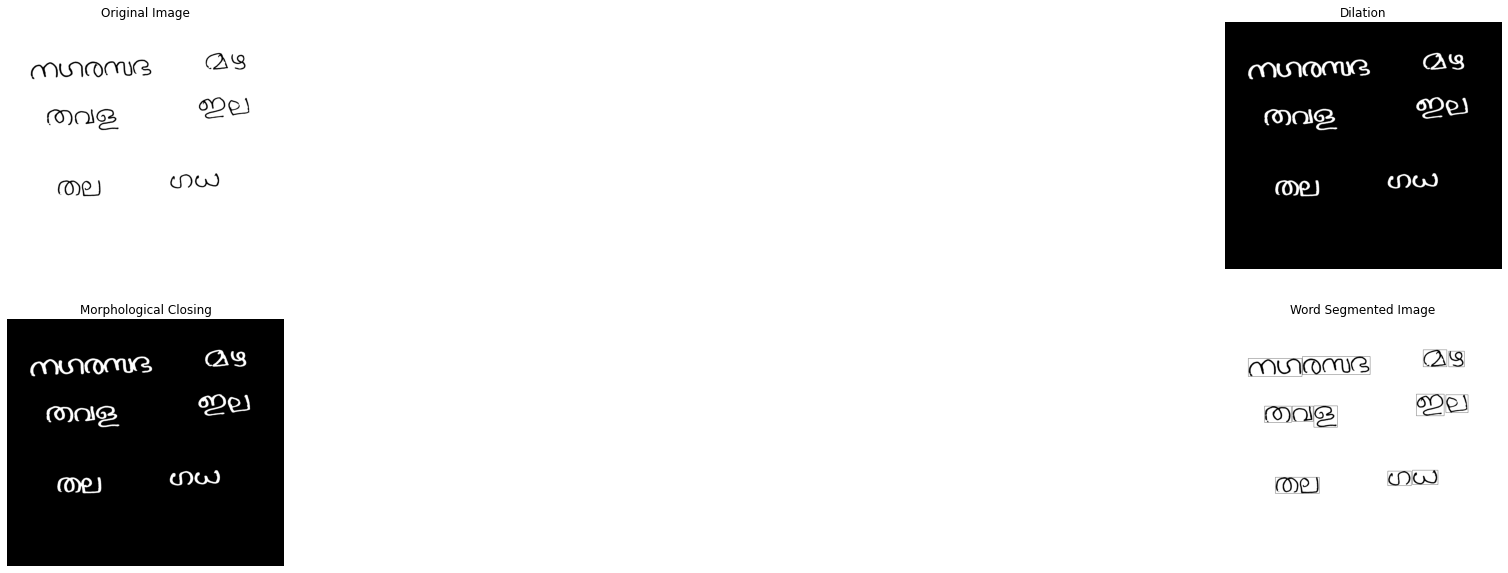

In [6]:
word_image = inp_img.copy()
for j, c in enumerate(contours):
    c_temp = cv2.boundingRect(c)
    if c_temp[2] <= 25 or c_temp[3] <= 25:
        continue
    x,y,w,h = c_temp
    cv2.rectangle(word_image, (x, y), (x + w, y + h), (0,0, 0), 2)
    


fig,axes = plt.subplots(2,2,figsize=(40,10))
axes[0,0].axis('off')
axes[0,0].imshow(inp_img,cmap='gray')
axes[0,0].set_title('Original Image')

axes[0,1].axis('off')
axes[0,1].imshow(dilate,cmap='gray')
axes[0,1].set_title('Dilation')

axes[1,0].axis('off')
axes[1,0].imshow(connected,cmap='gray')
axes[1,0].set_title('Morphological Closing')

axes[1,1].axis('off')
axes[1,1].imshow(word_image,cmap='gray')
axes[1,1].set_title('Word Segmented Image')


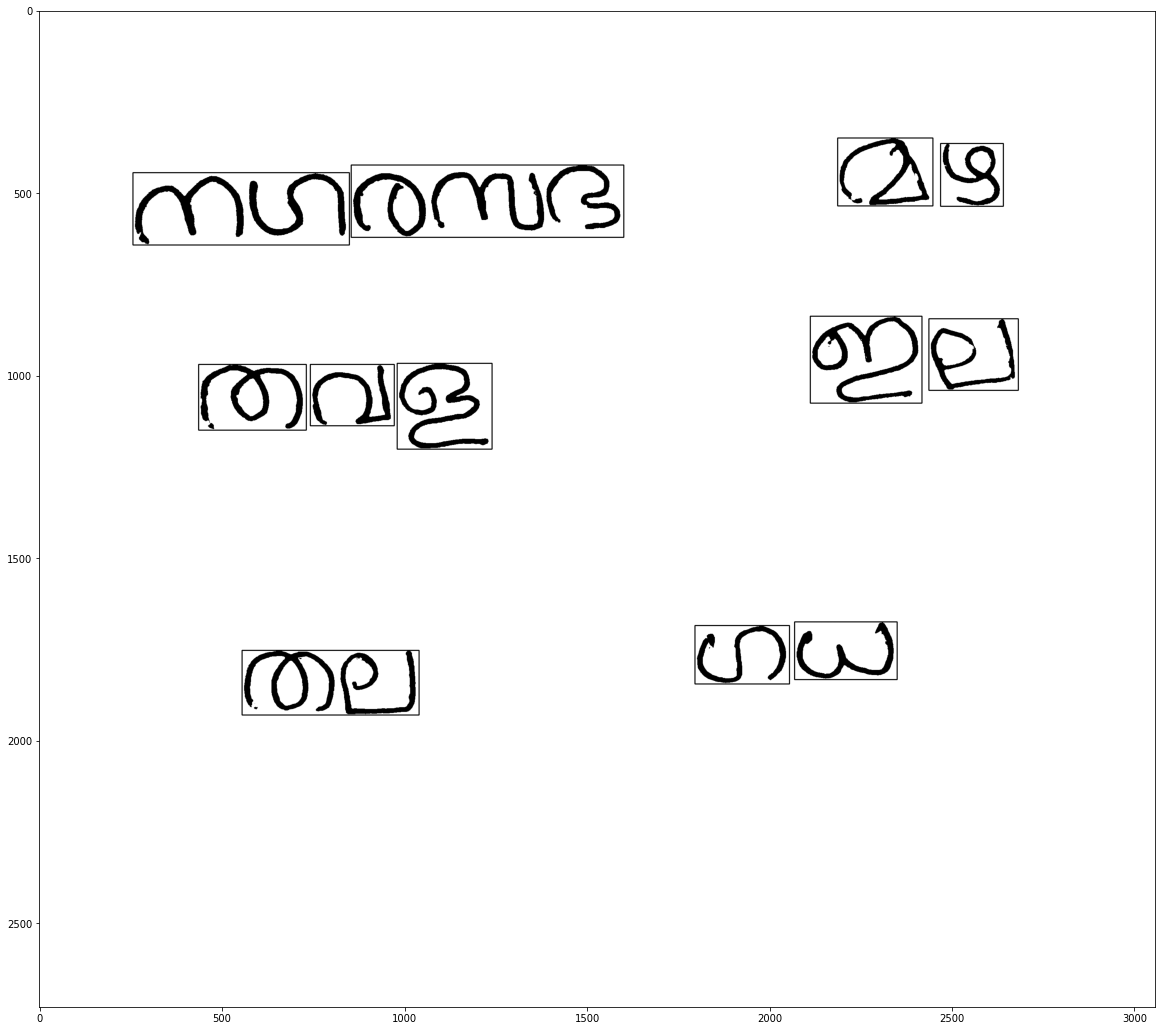

In [7]:
fig,axes = plt.subplots(figsize=(20,20))
plt.imshow(word_image,cmap='gray')
plt.show()

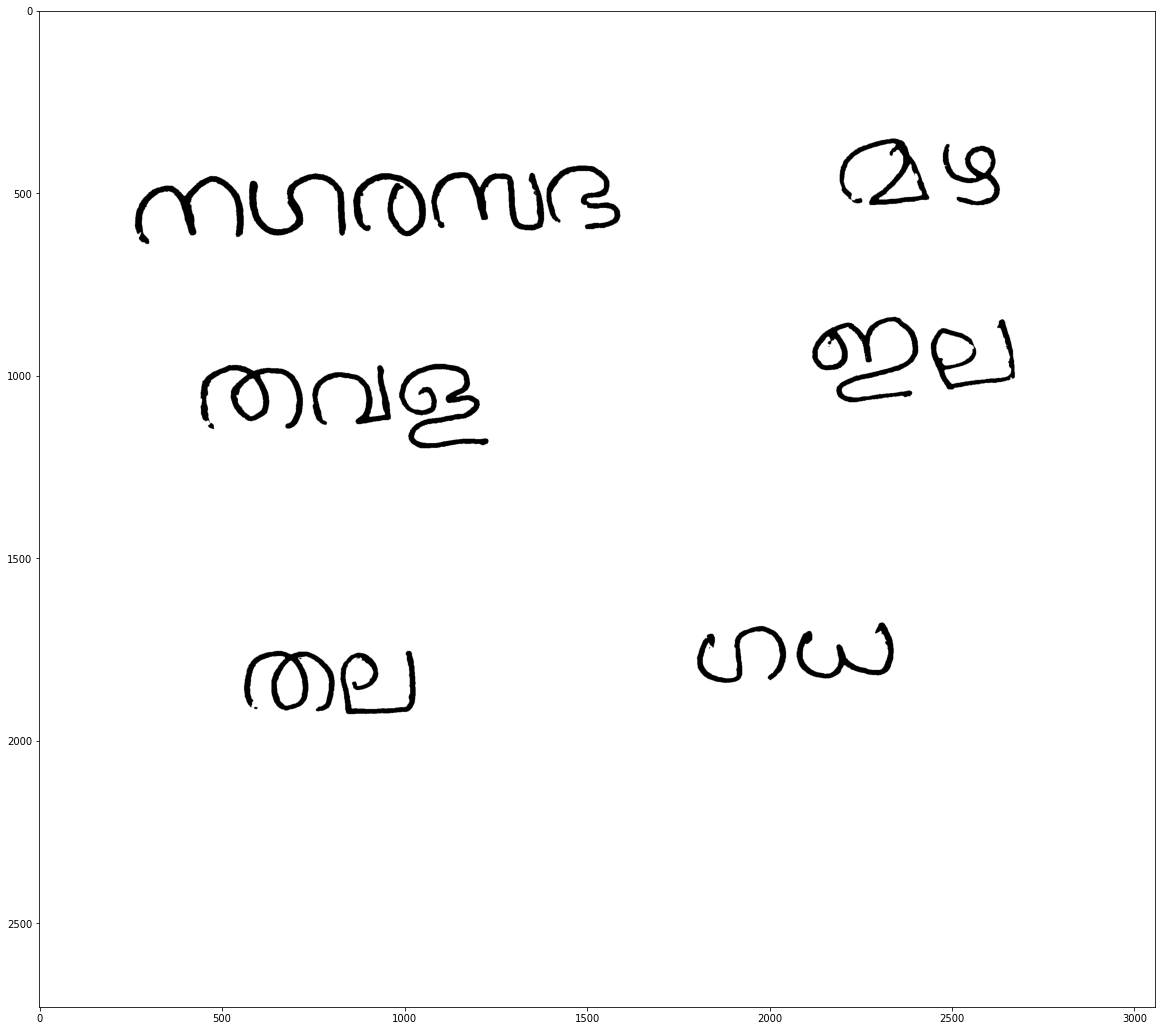

In [8]:
fig,axes = plt.subplots(figsize=(20,20))
plt.imshow(inp_img,cmap='gray')
plt.show()

# Character Segmentation

### Method 1

In [15]:
image = inp_img.copy()
ellipse=(3,3)
rect=(2,1)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ellipse)
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, rect)
kernel = np.ones(rect,np.uint8)

char_images_1 = []

for word in words:
    char_img = word.copy()
    img = cv2.bitwise_not(word)
    erosion = cv2.erode(img,kernel,iterations = 1)
    _, bw = cv2.threshold(erosion, threshold, 255.0,
                              cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(
        bw.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        c_temp = cv2.boundingRect(cnt)
#         if c_temp[2] <= 25 or c_temp[3] <= 25:
#             continue
        x,y,w,h = c_temp
        cv2.rectangle(char_img, (x, y), (x + w, y + h), (0,255, 0), 1)
    char_images_1.append(char_img)
    
#     plot_image(char_img)


### Method 2

In [9]:
image = inp_img.copy()
ellipse=(3,3)
rect=(2,1)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ellipse)
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, rect)

char_images_2 = []
chars = []
for word in words:
#     img = cv2.bitwise_not(word)
    char_img = word.copy()
    img = cv2.bitwise_not(word)
    erosion = cv2.erode(img,kernel2,iterations = 1)
    _, bw = cv2.threshold(erosion, threshold, 255.0,
                              cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(
        bw.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     plot_image(connected)
    # reversing contour list to start processig from top
    contours.reverse()
    b_rect = []
    cnts = []
    for c in contours:
        rect = cv2.boundingRect(c)
        if rect[2] <= 10 or rect[3] <= 10:
            continue
        b_rect.append(rect)
        cnts.append(c)
    sorted_cnt = [[y,x] for y, x in sorted(zip(b_rect, cnts), key=lambda pair: pair[0])]
    for rect,cnt in sorted_cnt:
        x,y,w,h = rect
        cv2.rectangle(char_img, (x, y), (x + w, y + h), (0,255, 0), 1)
        # removing overlap
        mask = np.zeros_like(word)
        cv2.drawContours(mask,[cnt], 0, (255,255,255), -1)
        new_image = cv2.bitwise_and(cv2.bitwise_not(word), mask)
        new_image = cv2.bitwise_not(new_image)

        char = new_image[y:y+h, x:x+w]
        char = cv2.copyMakeBorder(
                char, 20,20,20,20, cv2.BORDER_CONSTANT, value=[255, 255, 255])

        char = cv2.resize(char, (86, 86))
        chars.append(char)
    char_images_2.append(char_img)


[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255 255 255]
 [255 255

In [11]:
np.min(word)

0

### Method 3


In [17]:
image = inp_img.copy()
ellipse=(3,3)
rect=(2,1)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ellipse)
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, rect)

char_images_3 = []
chars = []
for word in words:
#     img = cv2.bitwise_not(word)
    char_img = word.copy()
    grad = cv2.morphologyEx(word, cv2.MORPH_GRADIENT, kernel)
#     word_copy = cv2.bitwise_not(word)
    _, bw = cv2.threshold(grad, threshold, 255.0,
                              cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel2)
    contours, hierarchy = cv2.findContours(
        connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     plot_image(connected)
    # reversing contour list to start processig from top
    contours.reverse()
    b_rect = []
    cnts = []
    for c in contours:
        rect = cv2.boundingRect(c)
        if rect[2] <= 10 or rect[3] <= 10:
            continue
        b_rect.append(rect)
        cnts.append(c)
    sorted_cnt = [[y,x] for y, x in sorted(zip(b_rect, cnts), key=lambda pair: pair[0])]
    for rect,cnt in sorted_cnt:
        x,y,w,h = rect
        cv2.rectangle(char_img, (x, y), (x + w, y + h), (0,255, 0), 1)
        # removing overlap
        mask = np.zeros_like(word)
        cv2.drawContours(mask,[cnt], 0, (255,255,255), -1)
        new_image = cv2.bitwise_and(cv2.bitwise_not(word), mask)
        new_image = cv2.bitwise_not(new_image)

        char = new_image[y:y+h, x:x+w]
        char = cv2.copyMakeBorder(
                char, 20,20,20,20, cv2.BORDER_CONSTANT, value=[255, 255, 255])

        char = cv2.resize(char, (86, 86))
        chars.append(char)
    char_images_3.append(char_img)
        


In [18]:
b_rect

[(6, 1, 268, 156)]

## Comparing Character Segmentaion Methods

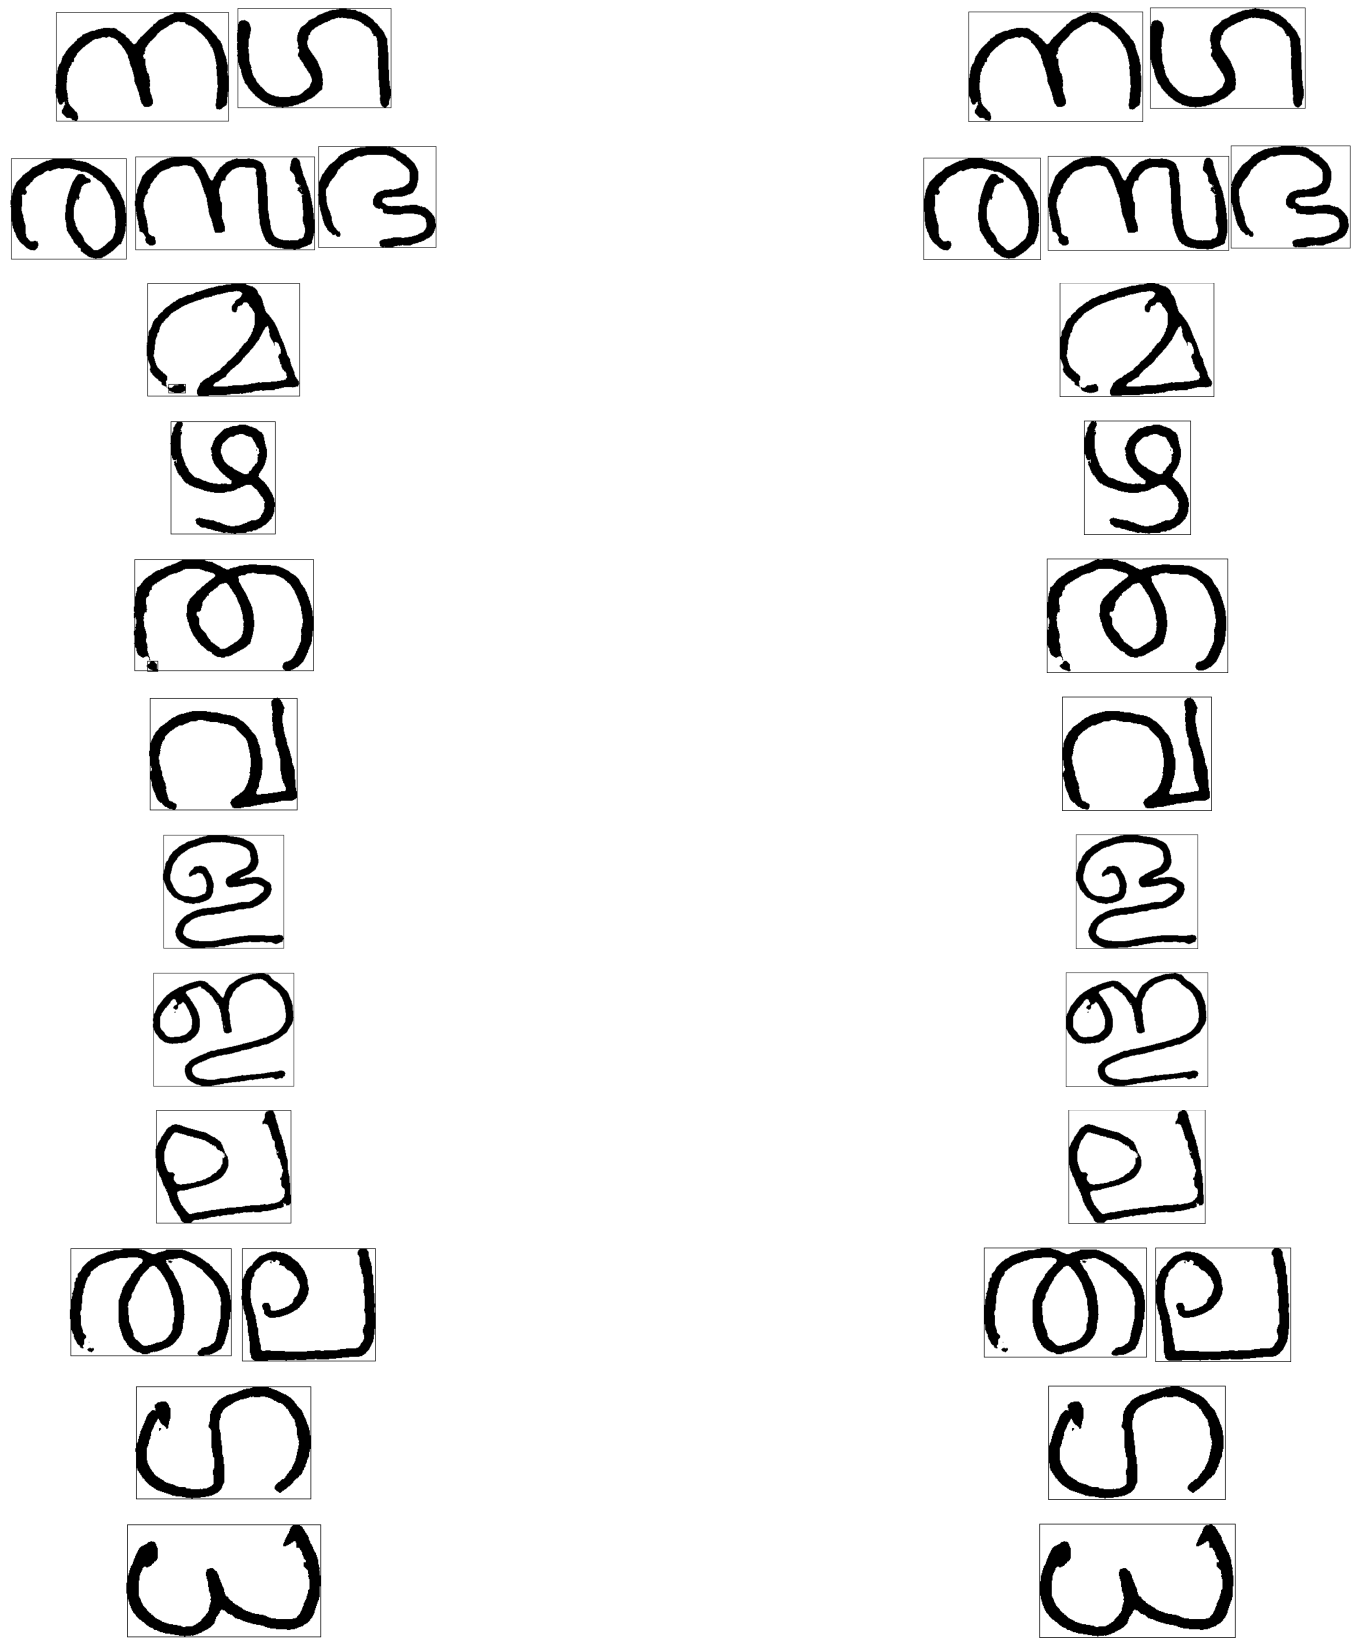

In [19]:
rows = max(len(char_images_2),len(char_images_3))
fig,axes = plt.subplots(rows,2,figsize=(30,30))

for i,char_image in enumerate(char_images_2):
    axes[i,0].axis('off')
    axes[i,0].imshow(char_image,cmap='gray')


for i,char_image in enumerate(char_images_3):
    axes[i,1].axis('off')
    axes[i,1].imshow(char_image,cmap='gray')
plt.show()

In [ ]:
cnt = con